**Siamese Network One-Shot**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import  numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
full_df = pd.read_csv('consolidated_SERS.csv')
full_df['Class'] = full_df['Label'].astype(str) + '__' + full_df['Substrate'].astype(str)

In [4]:
# 3) Split 20% train / 80% query per class
train_df,query_df = train_test_split(full_df,test_size=0.8, stratify=full_df['Class'], random_state=42)
train_df = train_df.reset_index(drop=True)
query_df = query_df.reset_index(drop=True)

In [5]:
# 4) Load averaged SERS per label-substrate as reference for Siamese
ref_avg = pd.read_csv('consolidated_SERS_avg.csv')
ref_avg['Class'] = ref_avg['Label'].astype(str) + '__' + ref_avg['Substrate'].astype(str)
# 5) Identify spectral columns
spectral_cols = [c for c in ref_avg.columns if c not in ['Label','Substrate','Class']]

# 6) Extract reference and query arrays and labels
ref_specs = ref_avg[spectral_cols].values.astype(float)
ref_labels = ref_avg['Class'].values

qry_specs = query_df[spectral_cols].values.astype(float)
qry_labels = query_df['Class'].values

In [6]:
lam, p, niter = 1e4, 0.01, 10
def baseline_als(y):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s)
        c = s - b
        norm = np.linalg.norm(c)
        out[i] = c / norm if norm > 0 else c
    return out

In [7]:
# Training data
train_specs = train_df[spectral_cols].values.astype(float)
train_labels = train_df['Class'].values
train_proc = preprocess(train_specs)

In [8]:
# Query data
qry_specs = query_df[spectral_cols].values.astype(float)
qry_labels = query_df['Class'].values
qry_proc = preprocess(qry_specs)

# Reference data (averages)
ref_specs = ref_avg[spectral_cols].values.astype(float)
ref_labels = ref_avg['Class'].values
ref_proc = preprocess(ref_specs)

In [9]:
np.unique(qry_labels)

array(['4np__AgNP', '4np__PICO', '4np__pSERS', 'benzenethiol__Ag',
       'benzenethiol__Au', 'bt__PICO', 'bt__pSERS',
       'n,n-dimethylformamide__AuNP', 'pyridine__AgNP', 'pyridine__AuNP',
       'pyridine__PICO', 'pyridine__pSERS'], dtype=object)

In [10]:
def augment(spec, noise_std=0.01, shift_max=2):
    spec_noisy = spec + np.random.normal(0, noise_std, size=spec.shape)
    shift = np.random.randint(-shift_max, shift_max + 1)
    return np.roll(spec_noisy, shift)

# 3. Pair dataset for contrastive learning
class RamanPairDataset(Dataset):
    def __init__(self, specs, labels, augment_fn=None):
        self.specs = specs
        self.labels = labels
        self.augment = augment_fn
        self.by_label = {c: np.where(labels == c)[0] for c in np.unique(labels)}

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        x1 = self.specs[idx]
        y1 = self.labels[idx]
        if np.random.rand() < 0.5:
            j = np.random.choice(self.by_label[y1])
            label = 1.0
        else:
            neg = [c for c in self.by_label if c != y1]
            y2 = np.random.choice(neg)
            j = np.random.choice(self.by_label[y2])
            label = 0.0
        x2 = self.specs[j]
        if self.augment:
            x1 = self.augment(x1)
            x2 = self.augment(x2)
        return (torch.tensor(x1, dtype=torch.float32).unsqueeze(0),
                torch.tensor(x2, dtype=torch.float32).unsqueeze(0),
                torch.tensor(label, dtype=torch.float32))

# 4. Siamese network definition
class SiameseNet(nn.Module):
    def __init__(self, input_len, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 32, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encoder(x)
        return F.normalize(z, dim=1)

# 5. Contrastive loss
def contrastive_loss(z1, z2, label, margin=1.0):
    dist = F.pairwise_distance(z1, z2)
    loss_pos = label * dist**2
    loss_neg = (1 - label) * F.relu(margin - dist)**2
    return (loss_pos + loss_neg).mean()

In [11]:
# 8) Prepare DataLoader, model, optimizer
input_len = train_proc.shape[1]
dataset = RamanPairDataset(train_proc, train_labels, augment_fn=augment)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
model = SiameseNet(input_len, embed_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 9) Train Siamese network
model.train()
for epoch in range(1, 101):
    total_loss = 0.0
    for x1, x2, lbl in loader:
        z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2, lbl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x1.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")



Epoch 1, Loss: 0.4630
Epoch 2, Loss: 0.4947
Epoch 3, Loss: 0.4811
Epoch 4, Loss: 0.2575
Epoch 5, Loss: 0.1714
Epoch 6, Loss: 0.3619
Epoch 7, Loss: 0.3021
Epoch 8, Loss: 0.2151
Epoch 9, Loss: 0.1361
Epoch 10, Loss: 0.2822
Epoch 11, Loss: 0.3010
Epoch 12, Loss: 0.1573
Epoch 13, Loss: 0.1914
Epoch 14, Loss: 0.1531
Epoch 15, Loss: 0.2044
Epoch 16, Loss: 0.2043
Epoch 17, Loss: 0.0967
Epoch 18, Loss: 0.0930
Epoch 19, Loss: 0.0598
Epoch 20, Loss: 0.0693
Epoch 21, Loss: 0.0313
Epoch 22, Loss: 0.0342
Epoch 23, Loss: 0.0597
Epoch 24, Loss: 0.0459
Epoch 25, Loss: 0.0539
Epoch 26, Loss: 0.0462
Epoch 27, Loss: 0.0338
Epoch 28, Loss: 0.0605
Epoch 29, Loss: 0.0650
Epoch 30, Loss: 0.0515
Epoch 31, Loss: 0.0514
Epoch 32, Loss: 0.0634
Epoch 33, Loss: 0.0691
Epoch 34, Loss: 0.0413
Epoch 35, Loss: 0.0170
Epoch 36, Loss: 0.0222
Epoch 37, Loss: 0.0467
Epoch 38, Loss: 0.0331
Epoch 39, Loss: 0.0332
Epoch 40, Loss: 0.0212
Epoch 41, Loss: 0.0363
Epoch 42, Loss: 0.0313
Epoch 43, Loss: 0.0217
Epoch 44, Loss: 0.02

In [12]:
# 10) Compute embeddings for reference and query
model.eval()
with torch.no_grad():
    ref_embeds = model(torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()
    qry_embeds = model(torch.tensor(qry_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# 11) 1‑NN classification of query against averaged references
pred_labels = []
for q in qry_embeds:
    idx = np.argmin(np.linalg.norm(ref_embeds - q, axis=1))
    pred_labels.append(ref_labels[idx])

In [13]:
ref_labels

array(['4np__AgNP', '4np__PICO', '4np__pSERS', 'benzenethiol__Ag',
       'benzenethiol__Au', 'bt__PICO', 'bt__pSERS',
       'n,n-dimethylformamide__AuNP', 'pyridine__AgNP', 'pyridine__AuNP',
       'pyridine__PICO', 'pyridine__pSERS'], dtype=object)

In [14]:
np.unique(qry_labels)

array(['4np__AgNP', '4np__PICO', '4np__pSERS', 'benzenethiol__Ag',
       'benzenethiol__Au', 'bt__PICO', 'bt__pSERS',
       'n,n-dimethylformamide__AuNP', 'pyridine__AgNP', 'pyridine__AuNP',
       'pyridine__PICO', 'pyridine__pSERS'], dtype=object)

Top‑1 Accuracy: 98.76%

Classification Report:
                             precision    recall  f1-score   support

                  4np__AgNP       0.90      0.90      0.90        20
                  4np__PICO       1.00      1.00      1.00        20
                 4np__pSERS       1.00      1.00      1.00        20
           benzenethiol__Ag       0.91      1.00      0.95        20
           benzenethiol__Au       1.00      1.00      1.00        20
                   bt__PICO       1.00      1.00      1.00        20
                  bt__pSERS       1.00      1.00      1.00        20
n,n-dimethylformamide__AuNP       1.00      0.99      1.00       183
             pyridine__AgNP       1.00      0.90      0.95        20
             pyridine__AuNP       0.95      1.00      0.98        20
             pyridine__PICO       1.00      1.00      1.00        20
            pyridine__pSERS       1.00      1.00      1.00        20

                   accuracy                           

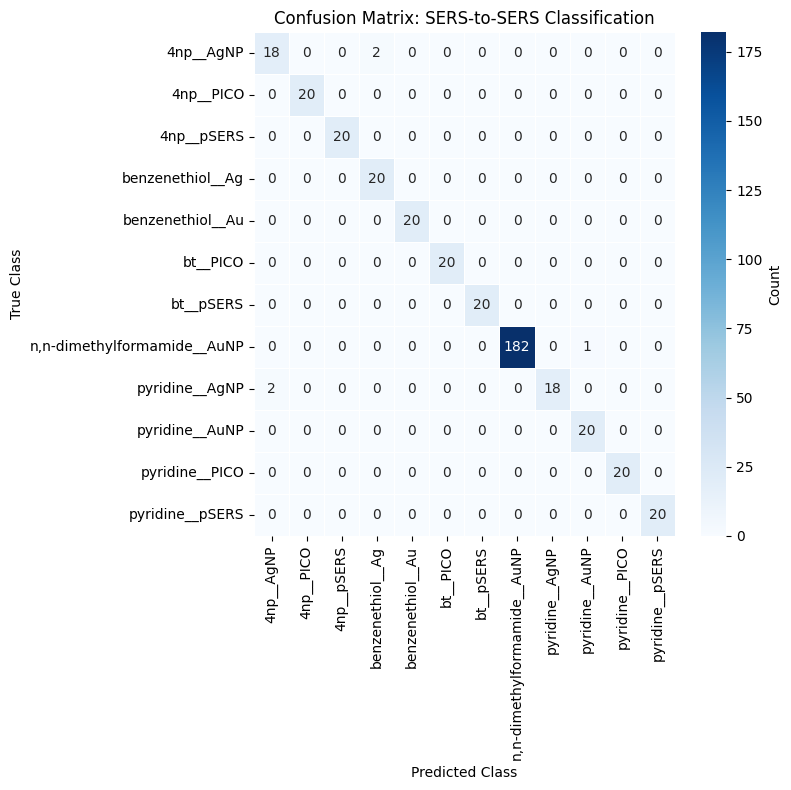

In [15]:
# 12) Evaluation
acc = accuracy_score(qry_labels, pred_labels)
print(f"Top‑1 Accuracy: {acc:.2%}\n")
print("Classification Report:")
print(classification_report(qry_labels, pred_labels, target_names=np.unique(ref_labels)))

# 13) Confusion matrix plot
classes = np.unique(ref_labels)
cm = confusion_matrix(qry_labels, pred_labels, labels=classes)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label':'Count'}, linewidths=0.5)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix: SERS‑to‑SERS Classification')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils

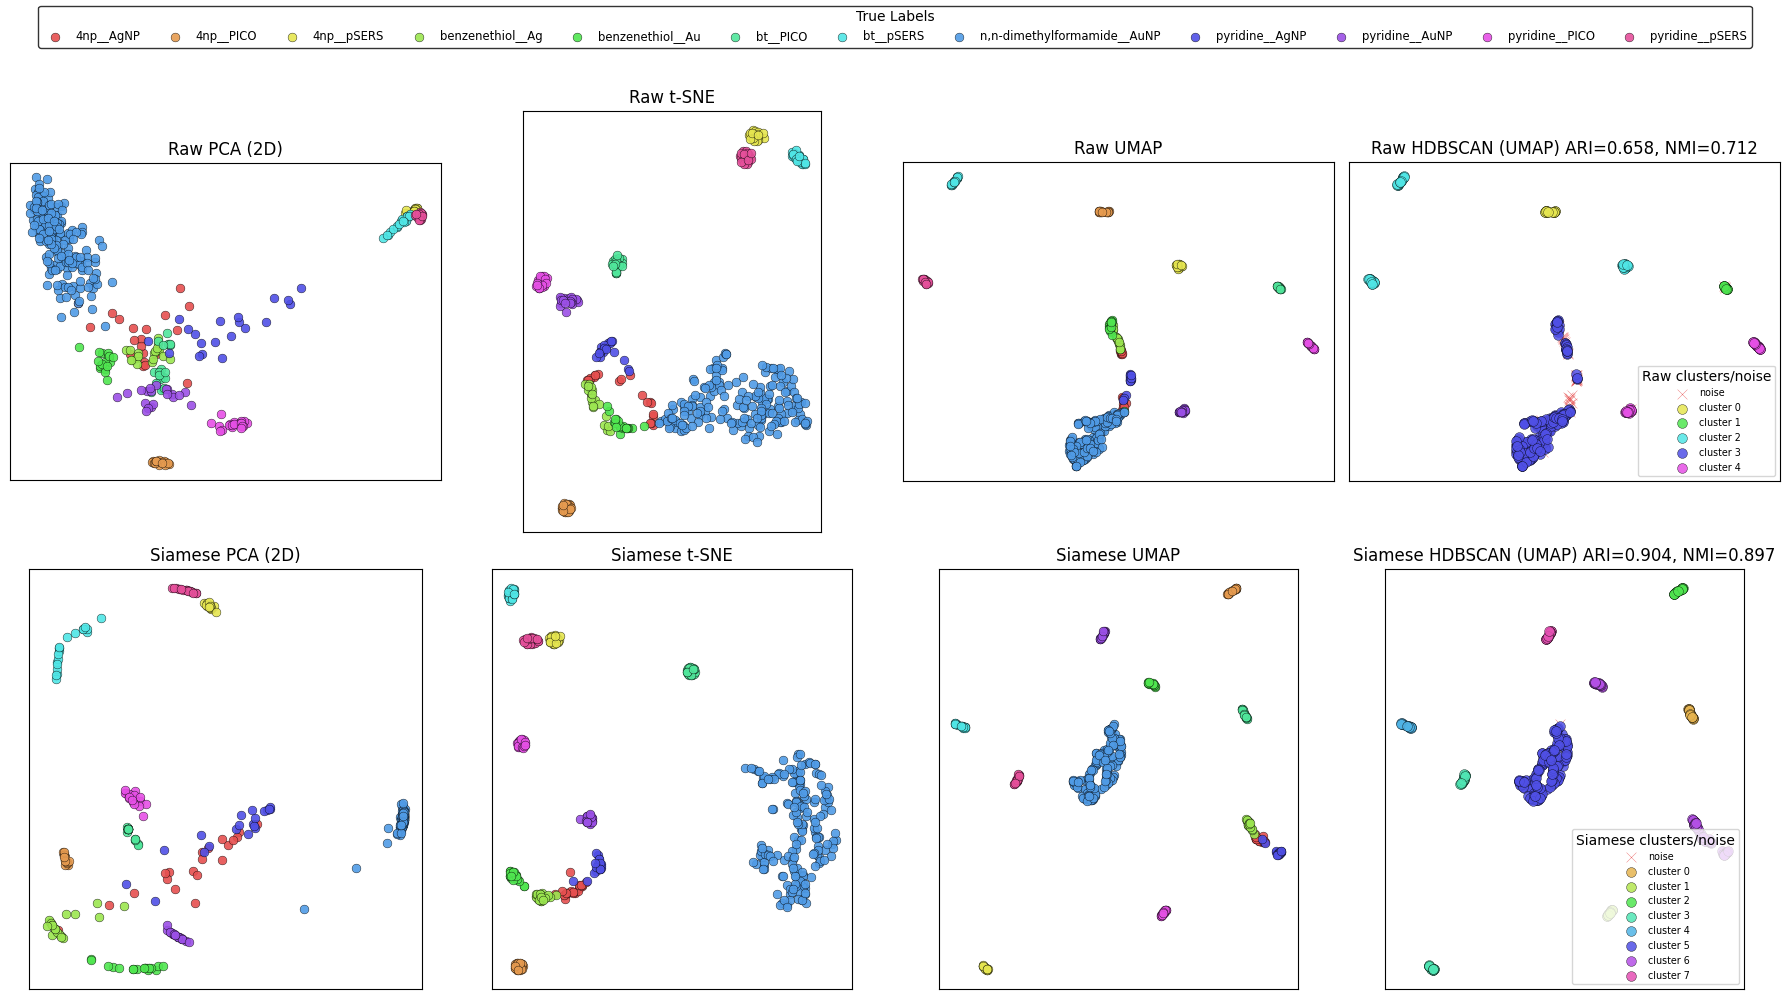

Raw HDBSCAN -> ARI: 0.6576, NMI: 0.7117
Siamese HDBSCAN -> ARI: 0.9036, NMI: 0.8968


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import colorsys

# --- helpers for distinct colors ---
def make_distinct_colors(n, saturation=0.65, value=0.9):
    """
    Returns n visually distinct RGB colors by sampling evenly in HSV space.
    """
    hues = np.linspace(0, 1, n, endpoint=False)
    colors = [colorsys.hsv_to_rgb(h, saturation, value) for h in hues]
    return colors

def scatter_2d(proj, labels, title, ax, palette=None):
    unique = np.unique(labels)
    if palette is None:
        palette = make_distinct_colors(len(unique))
    color_map = {lbl: palette[i % len(palette)] for i, lbl in enumerate(unique)}
    for lbl in unique:
        mask = labels == lbl
        ax.scatter(
            proj[mask, 0],
            proj[mask, 1],
            label=lbl,
            s=40,
            alpha=0.9,
            edgecolor='black',
            linewidth=0.3,
            color=color_map[lbl],
        )
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')

# Assume qry_proc, qry_embeds, qry_labels in scope
# Build palettes
unique_labels = np.unique(qry_labels)
label_palette = make_distinct_colors(len(unique_labels))

# Prepare projections
pca_raw = PCA(n_components=2, random_state=0).fit_transform(qry_proc)
pca_embed = PCA(n_components=2, random_state=0).fit_transform(qry_embeds)

tsne_raw = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=0).fit_transform(qry_proc)
tsne_embed = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=0).fit_transform(qry_embeds)

umap_raw = umap.UMAP(n_components=2, random_state=0).fit_transform(qry_proc)
umap_embed = umap.UMAP(n_components=2, random_state=0).fit_transform(qry_embeds)

# HDBSCAN on original spaces
cluster_raw = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(qry_proc)
cluster_siam = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(qry_embeds)
clust_labels_raw = cluster_raw.labels_
clust_labels_siam = cluster_siam.labels_

# Metrics
ari_raw = adjusted_rand_score(qry_labels, clust_labels_raw)
nmi_raw = normalized_mutual_info_score(qry_labels, clust_labels_raw)
ari_siam = adjusted_rand_score(qry_labels, clust_labels_siam)
nmi_siam = normalized_mutual_info_score(qry_labels, clust_labels_siam)

# Plot grid
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
# Row 0: raw
scatter_2d(pca_raw, qry_labels, "Raw PCA (2D)", axes[0, 0], palette=label_palette)
scatter_2d(tsne_raw, qry_labels, "Raw t-SNE", axes[0, 1], palette=label_palette)
scatter_2d(umap_raw, qry_labels, "Raw UMAP", axes[0, 2], palette=label_palette)

# HDBSCAN clusters in UMAP space for raw
unique_cr = np.unique(clust_labels_raw)
cluster_palette_raw = make_distinct_colors(len(unique_cr))
for i, cl in enumerate(unique_cr):
    mask = clust_labels_raw == cl
    label_name = "noise" if cl == -1 else f"cluster {cl}"
    marker = 'x' if cl == -1 else 'o'
    axes[0, 3].scatter(
        umap_raw[mask, 0],
        umap_raw[mask, 1],
        label=label_name,
        s=50,
        alpha=0.85,
        marker=marker,
        edgecolor='black',
        linewidth=0.3,
        color=cluster_palette_raw[i],
    )
axes[0, 3].set_title(f"Raw HDBSCAN (UMAP) ARI={ari_raw:.3f}, NMI={nmi_raw:.3f}")
axes[0, 3].set_xticks([])
axes[0, 3].set_yticks([])
axes[0, 3].set_aspect('equal', 'box')

# Row 1: siamese
scatter_2d(pca_embed, qry_labels, "Siamese PCA (2D)", axes[1, 0], palette=label_palette)
scatter_2d(tsne_embed, qry_labels, "Siamese t-SNE", axes[1, 1], palette=label_palette)
scatter_2d(umap_embed, qry_labels, "Siamese UMAP", axes[1, 2], palette=label_palette)

# HDBSCAN clusters in UMAP space for siamese
unique_cs = np.unique(clust_labels_siam)
cluster_palette_siam = make_distinct_colors(len(unique_cs))
for i, cl in enumerate(unique_cs):
    mask = clust_labels_siam == cl
    label_name = "noise" if cl == -1 else f"cluster {cl}"
    marker = 'x' if cl == -1 else 'o'
    axes[1, 3].scatter(
        umap_embed[mask, 0],
        umap_embed[mask, 1],
        label=label_name,
        s=50,
        alpha=0.85,
        marker=marker,
        edgecolor='black',
        linewidth=0.3,
        color=cluster_palette_siam[i],
    )
axes[1, 3].set_title(f"Siamese HDBSCAN (UMAP) ARI={ari_siam:.3f}, NMI={nmi_siam:.3f}")
axes[1, 3].set_xticks([])
axes[1, 3].set_yticks([])
axes[1, 3].set_aspect('equal', 'box')

# Shared legend for true labels (take from one of the label plots)
handles, label_names = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(handles, label_names, loc='upper center', ncol=min(12, len(label_names)), frameon=True,
                 title="True Labels", fontsize='small')
leg.get_frame().set_edgecolor('black')

# Individual cluster legends
axes[0, 3].legend(loc='lower right', fontsize='x-small', title="Raw clusters/noise")
axes[1, 3].legend(loc='lower right', fontsize='x-small', title="Siamese clusters/noise")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Summary print
print(f"Raw HDBSCAN -> ARI: {ari_raw:.4f}, NMI: {nmi_raw:.4f}")
print(f"Siamese HDBSCAN -> ARI: {ari_siam:.4f}, NMI: {nmi_siam:.4f}")


c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


--- Raw ---
ARI: 0.6576, NMI: 0.7117, Purity: 0.6799, Silhouette: 0.3825
Intra-class dist: 0.4598, Inter-class dist: 0.9990, Inter/Intra ratio: 2.17
--- Siamese ---
ARI: 0.9036, NMI: 0.8968, Purity: 0.8015, Silhouette: 0.7605
Intra-class dist: 0.0808, Inter-class dist: 1.2279, Inter/Intra ratio: 15.20


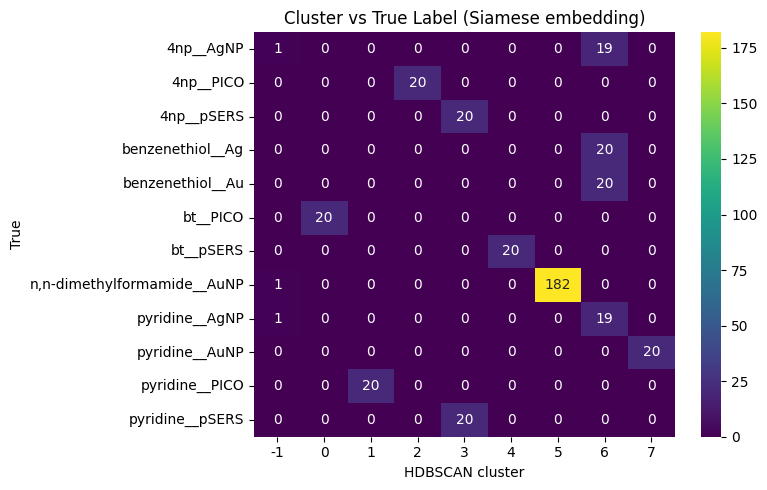

In [17]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, pairwise_distances
from collections import Counter
import numpy as np
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

def purity_score(true_labels, cluster_labels):
    # Assign majority true label to each cluster
    contingency = {}
    for cl, tl in zip(cluster_labels, true_labels):
        contingency.setdefault(cl, []).append(tl)
    correct = sum(Counter(contingency[c]).most_common(1)[0][1] for c in contingency)
    return correct / len(true_labels)

def intra_inter_ratio(embeds, labels):
    same, diff = [], []
    N = len(embeds)
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(embeds[i] - embeds[j])
            if labels[i] == labels[j]:
                same.append(d)
            else:
                diff.append(d)
    same_mean = np.mean(same)
    diff_mean = np.mean(diff)
    return same_mean, diff_mean, diff_mean / (same_mean + 1e-12)

# Example for raw and siamese clustering results
# Assume: qry_proc, qry_embeds, qry_labels in scope
import hdbscan
cluster_raw = hdbscan.HDBSCAN(min_cluster_size=15).fit(qry_proc)
cluster_siam = hdbscan.HDBSCAN(min_cluster_size=15).fit(qry_embeds)
clust_raw = cluster_raw.labels_
clust_siam = cluster_siam.labels_

# Metrics
for name, clust_labels, embeds in [
    ("Raw", clust_raw, qry_proc),
    ("Siamese", clust_siam, qry_embeds)
]:
    ari = adjusted_rand_score(qry_labels, clust_labels)
    nmi = normalized_mutual_info_score(qry_labels, clust_labels)
    purity = purity_score(qry_labels, clust_labels)
    sil = silhouette_score(embeds, clust_labels) if len(set(clust_labels)) > 1 else np.nan
    intra, inter, ratio = intra_inter_ratio(embeds, qry_labels)
    print(f"--- {name} ---")
    print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}, Purity: {purity:.4f}, Silhouette: {sil:.4f}")
    print(f"Intra-class dist: {intra:.4f}, Inter-class dist: {inter:.4f}, Inter/Intra ratio: {ratio:.2f}")

# Contingency heatmap (for Siamese as example)
import pandas as pd
ct = pd.crosstab(qry_labels, clust_siam, rownames=['True'], colnames=['HDBSCAN cluster'])
plt.figure(figsize=(8,5))
sns.heatmap(ct, annot=True, fmt='d', cmap='viridis')
plt.title("Cluster vs True Label (Siamese embedding)")
plt.tight_layout()
plt.show()
